In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyaadharshinivs062/leukemia-dataset-02")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/leukemia-dataset-02


In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

In [3]:
# Dataset Paths
dataset_base_path = "/kaggle/input/leukemia-dataset-02/archive (1)"
train_dir = os.path.join(dataset_base_path, "train")
test_dir = os.path.join(dataset_base_path, "test")

print("Training Directory:", train_dir)
print("Testing Directory:", test_dir)

# Verify class folders inside the train directory
print("Classes in training directory:", os.listdir(train_dir))


Training Directory: /kaggle/input/leukemia-dataset-02/archive (1)/train
Testing Directory: /kaggle/input/leukemia-dataset-02/archive (1)/test
Classes in training directory: ['CML', 'H', 'ALL', 'AML', 'CLL']


In [4]:
# Class mapping
class_map = {'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'H': 4}
classes = list(class_map.keys())

# Function to collect image paths and labels
def collect_data(data_dir):
    image_paths = []
    labels = []
    for class_name, class_label in class_map.items():
        class_folder = os.path.join(data_dir, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_folder, file))
                    labels.append(class_label)
        else:
            print(f"Directory {class_folder} not found")
    return image_paths, labels

Displaying images from: /kaggle/input/leukemia-dataset-02/archive (1)/train


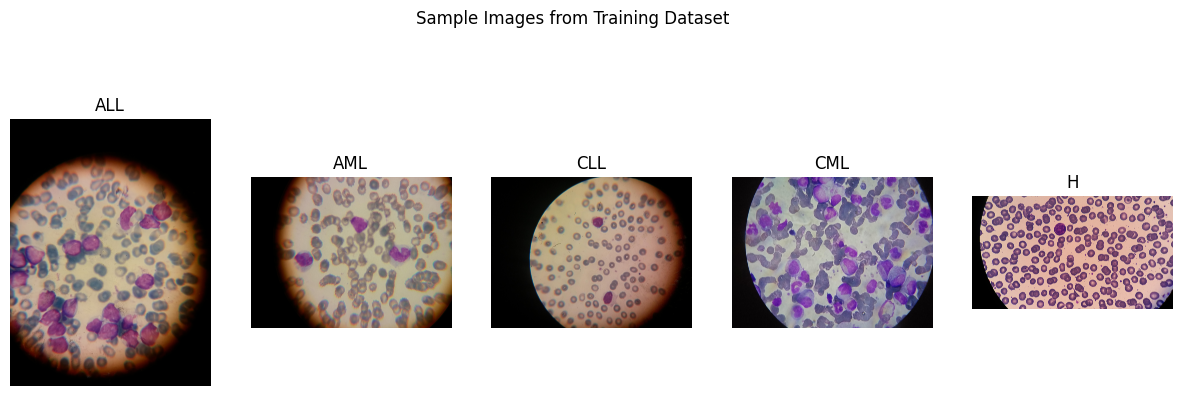

Total training images: 15000
Total testing images: 5000


In [5]:
# Function to count total images in a directory
def count_total_images(directory):
    total_images = 0
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        # Count all image files in the folder
        total_images += len([img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total_images

# Function to display one image per class
def show_images_from_each_class(directory, title):
    print(f"Displaying images from: {directory}")
    plt.figure(figsize=(15, 5))  # Set the plot size
    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        # List all image files in the folder
        image_files = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:
            image_path = os.path.join(class_path, image_files[0])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            plt.subplot(1, len(classes), i + 1)  # Create a subplot for each class
            plt.imshow(image)
            plt.title(class_name)
            plt.axis("off")  # Remove axis for better visualization
    plt.suptitle(title)
    plt.show()

# Show one image per class
show_images_from_each_class(train_dir, "Sample Images from Training Dataset")

# Count total images in train and test directories
total_train_images = count_total_images(train_dir)
total_test_images = count_total_images(test_dir)

# Print the total number of images
print(f"Total training images: {total_train_images}")
print(f"Total testing images: {total_test_images}")


In [6]:
# Create an ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image values to [0,1]
    rotation_range=5,  # Random rotation between -30 and 30 degrees
    width_shift_range=0.05,  # Random horizontal shift
    height_shift_range=0.05,  # Random vertical shift
    shear_range=0.22,  # Random shear transformation
    zoom_range=0.05,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # Filling strategy for missing pixels
    validation_split=0.1  # Use 10% of the training data for validation
)

# Flow training images using the generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Resize images to a consistent shape (e.g., 224x224)
    batch_size=32,  # Choose an appropriate batch size
    class_mode='sparse',  # Set to 'sparse' if labels are integers
    subset='training',  # Use the training subset (90% of the data)
    shuffle=True  # Shuffle the data during training
)

# Flow validation images using the generator (10% of the training data)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Resize images to a consistent shape (e.g., 224x224)
    batch_size=32,  # Choose an appropriate batch size
    class_mode='sparse',  # Set to 'sparse' if labels are integers
    subset='validation',  # Use the validation subset (10% of the training data)
    shuffle=False  # No need to shuffle the validation set
)

# Create a separate ImageDataGenerator for the test data (with normalization)
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize image values to [0,1]
)

# Flow test images using the generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # Resize images to a consistent shape (e.g., 224x224)
    batch_size=32,  # Choose an appropriate batch size
    class_mode='sparse',  # Set to 'sparse' if labels are integers
    shuffle=False  # No need to shuffle the test set
)


Found 13500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


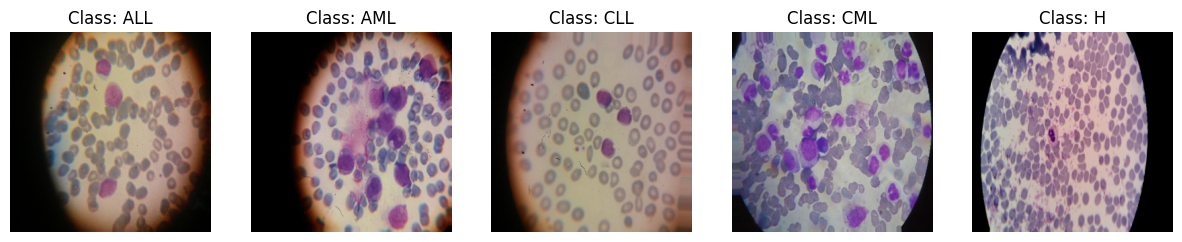

In [7]:
# Function to visualize one image from each class after augmentation
def show_one_image_from_each_class(generator, num_classes=5):
    # Initialize a figure with subplots for each class
    plt.figure(figsize=(15, 5))
    
    # Loop over each class
    for class_idx in range(num_classes):
        # Find the image corresponding to this class
        while True:
            # Get a batch of images and labels
            images, labels = next(generator)
            
            # Check if the batch contains an image from the current class
            if class_idx in labels:
                # Find the index of the image of this class in the batch
                class_image_index = list(labels).index(class_idx)
                
                # Get the corresponding image
                image = images[class_image_index]
                
                # Plot the image
                plt.subplot(1, num_classes, class_idx + 1)  # Create a subplot for each class
                plt.imshow(image)
                plt.title(f"Class: {classes[class_idx]}")
                plt.axis('off')  # Remove axis for better visualization
                break
    
    # Display the image grid
    plt.show()

# Visualize one augmented image from each class
show_one_image_from_each_class(train_generator)


In [8]:
# Clear the session
K.clear_session()

# Load the Xception model without the top layer, to use it as a feature extractor
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Create the model using the functional API
inputs = layers.Input(shape=(299, 299, 3))  # Input layer
x = base_model(inputs)  # Pass the input through the base model
x = layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = layers.Dense(128, activation='relu')(x)  # Dense layer with 128 units
x = layers.Dropout(0.5)(x)  # Dropout layer
outputs = layers.Dense(len(classes), activation='softmax')(x)  # Output layer

# Create the final model
model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,397 (80.58 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:

print(f'Total layers in Xception: {len(base_model.layers)}')


Total layers in Xception: 132


In [10]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the data generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1,  # You can adjust this based on your dataset size
    verbose=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 ━━━━━━━━━━━━━━━━━━━━ 1767s 4s/step - accuracy: 0.7626 - loss: 0.6195 - val_accuracy: 0.8980 - val_loss: 0.2737


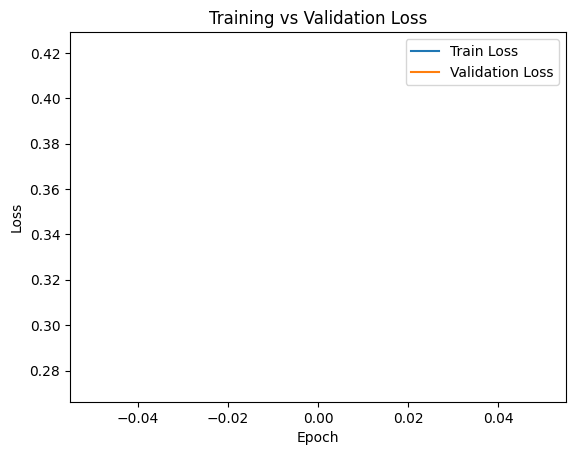

In [11]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [12]:
# Save the model in the Keras format
model.save('Xception_leukemia_classification.keras')


In [13]:
import shutil

# Zip the saved model file
shutil.make_archive('Xception_leukemia_classification', 'zip', '.', 'Xception_leukemia_classification.keras') 

'/kaggle/working/Xception_leukemia_classification.zip'

In [ ]:
'''
# Load the model
model_path = "......"
model = tf.keras.models.load_model(model_path)
'''

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.5876 - loss: 1.3308
Test Loss: 0.6962697505950928
Test Accuracy: 0.7803999781608582


In [ ]:
# Generate predictions for the test set
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator, verbose=1)  # Model predictions

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


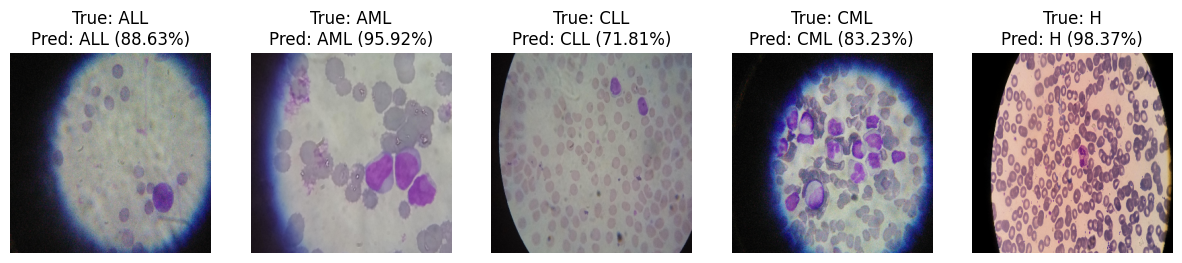

In [15]:
def visualize_predictions_with_true_class(generator, model, num_classes=5):
    plt.figure(figsize=(15, 5))
    
    # Loop through the classes
    for class_idx in range(num_classes):
        while True:
            # Get a batch of images and labels
            images, labels = next(generator)
            
            # Check if the batch contains an image from the current class
            if class_idx in labels:
                # Find the index of the image of this class in the batch
                class_image_index = list(labels).index(class_idx)
                
                # Get the image and make a prediction
                image = images[class_image_index]
                image_resized = np.expand_dims(image, axis=0)  # Add batch dimension
                prediction = model.predict(image_resized)
                predicted_class_idx = np.argmax(prediction)
                predicted_class = classes[predicted_class_idx]
                confidence = prediction[0][predicted_class_idx] * 100  # Prediction confidence
                true_class = classes[class_idx]  # True class name
                
                # Plot the image with its true class, predicted class, and confidence
                plt.subplot(1, num_classes, class_idx + 1)
                plt.imshow(image)
                plt.title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.2f}%)")
                plt.axis('off')  # Remove axis for better visualization
                break
    
    # Display the image grid
    plt.show()

# Visualize predictions from each class along with true class names
visualize_predictions_with_true_class(test_generator, model)


Found 5000 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


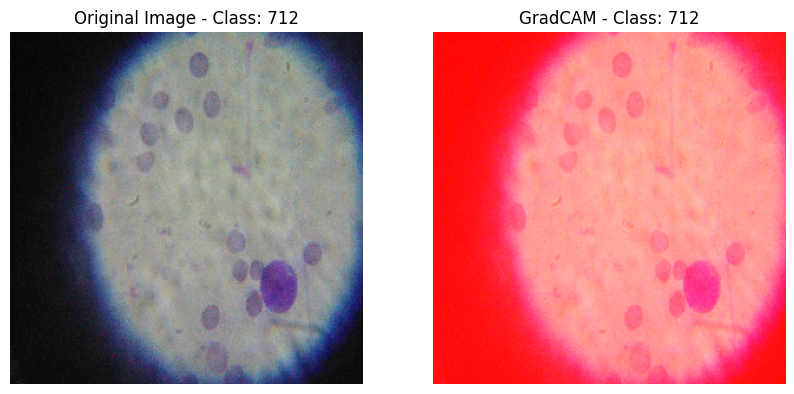

In [18]:
class GradCAM:
    def __init__(self, model, classIdx=None, layerName=None):
        self.model = model
        self.classIdx = classIdx
        # Use 'block13_sepconv1' which seems to be a valid layer
        self.layerName = layerName or 'block13_sepconv1'  # default to 'block13_sepconv1'

    def compute_heatmap(self, image, eps=1e-8):
        # Create a gradient model that outputs both the target convolutional layer and the model's final output
        gradModel = tf.keras.models.Model(inputs=[self.model.inputs],
                                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            # Pass the inputs through the model with training=False for inference mode
            convOutputs, predictions = gradModel(inputs, training=False)
            loss = predictions[:, self.classIdx]  # Focus on the target class

        # Get the gradients of the target class with respect to the output feature map
        grads = tape.gradient(loss, convOutputs)

        # Pool the gradients across all the axes (height, width) to get the importance of each feature map
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Convert convOutputs to numpy array to perform operations
        convOutputs = convOutputs[0].numpy()

        # Multiply each channel in the feature map by the corresponding pooled gradient
        for i in range(convOutputs.shape[-1]):
            convOutputs[:, :, i] *= pooled_grads[i]

        # Create the heatmap by averaging the feature map across all channels
        heatmap = np.mean(convOutputs, axis=-1)

        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap = heatmap / (np.max(heatmap) + eps)
        return heatmap

    def overlay_heatmap(self, heatmap, img, alpha=0.4):
        # Resize the heatmap to match the size of the input image
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]

        # Apply the colormap to the heatmap
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose the heatmap on the image
        superimposed_img = heatmap * alpha + img
        return superimposed_img

    def visualize_predictions_with_gradcam(self, generator, num_classes=5):
        for idx, (image, label) in enumerate(generator):
            if idx >= 1:  # Visualize only the first batch
                break
            # Get the predicted class index
            preds = self.model.predict(image)
            class_idx = np.argmax(preds, axis=-1)[0]  # Get the first image in the batch's predicted class index

            # Compute GradCAM heatmap
            heatmap = self.compute_heatmap(np.expand_dims(image[0], axis=0))  # Add batch dimension

            # Overlay heatmap on the image
            heatmap_img = self.overlay_heatmap(heatmap, image[0])

            # Plot the original image and GradCAM visualization
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(image[0])  # Original image
            plt.title(f"Original Image - Class: {class_idx}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(heatmap_img)  # Image with heatmap overlay
            plt.title(f"GradCAM - Class: {class_idx}")
            plt.axis('off')

            plt.show()


# Set up the model (make sure it's already trained or load the pre-trained model)
# Example with Xception model:
model = tf.keras.applications.Xception(weights='imagenet')  # Adjust with your model

# Define the data generator for test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)  # Normalize images to [0,1] range

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/leukemia-dataset-02/archive (1)/test',  # Replace with the correct path to your test data
    target_size=(299, 299),  # Adjust the image size to match the model input
    batch_size=16,          # Adjust the batch size
    class_mode='categorical',  # Assuming you have categorical labels
    shuffle=False           # Keep shuffle=False for consistent output
)

# Create GradCAM object
cam = GradCAM(model, classIdx=0)  # Set the target class index (e.g., 0 for the first class)

# Visualize GradCAM predictions for the test generator
cam.visualize_predictions_with_gradcam(test_generator, num_classes=5)


Found 5000 images belonging to 5 classes.


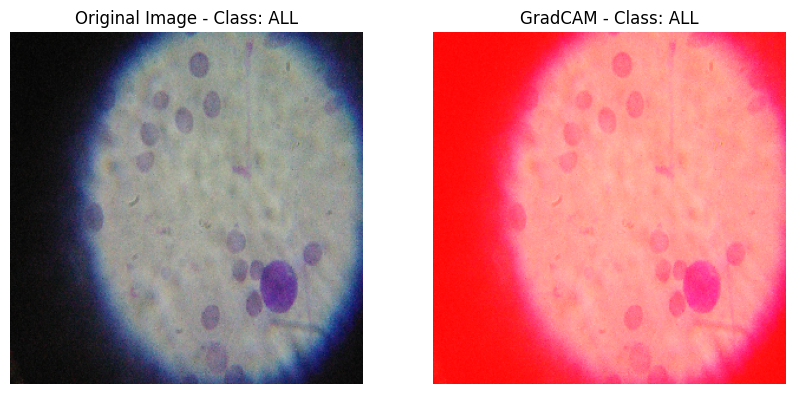

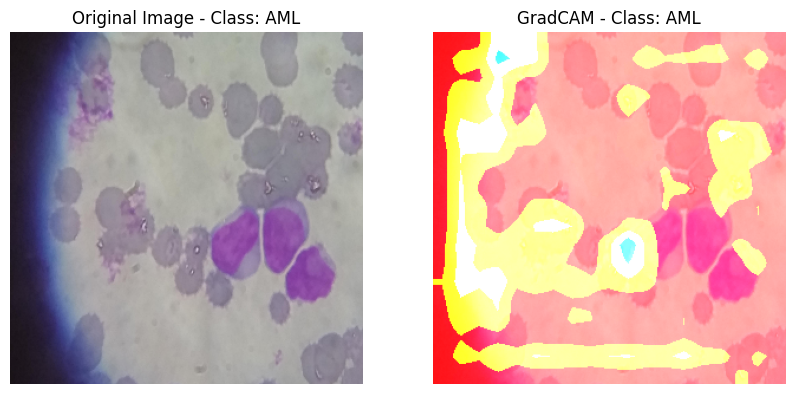

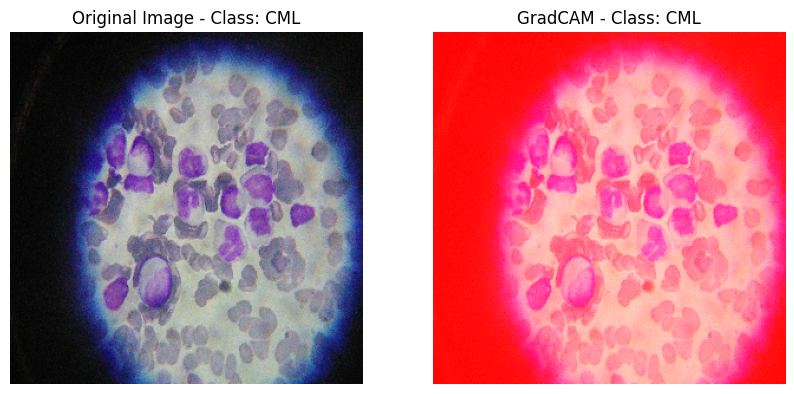

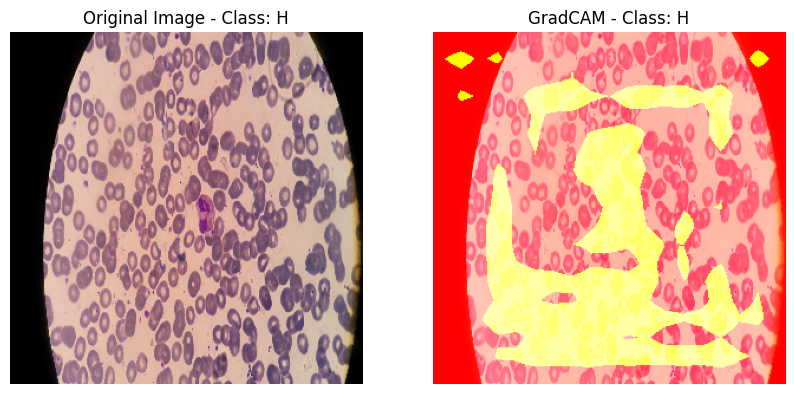

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2  # for resizing and applying the colormap

class GradCAM:
    def __init__(self, model, layerName=None):
        self.model = model
        # Use 'block13_sepconv1' which seems to be a valid layer
        self.layerName = layerName or 'block13_sepconv1'  # default to 'block13_sepconv1'

    def compute_heatmap(self, image, classIdx, eps=1e-8):
        # Create a gradient model that outputs both the target convolutional layer and the model's final output
        gradModel = tf.keras.models.Model(inputs=[self.model.inputs],
                                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            # Pass the inputs through the model with training=False for inference mode
            convOutputs, predictions = gradModel(inputs, training=False)
            loss = predictions[:, classIdx]  # Focus on the target class

        # Get the gradients of the target class with respect to the output feature map
        grads = tape.gradient(loss, convOutputs)

        # Pool the gradients across all the axes (height, width) to get the importance of each feature map
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Convert convOutputs to numpy array to perform operations
        convOutputs = convOutputs[0].numpy()

        # Multiply each channel in the feature map by the corresponding pooled gradient
        for i in range(convOutputs.shape[-1]):
            convOutputs[:, :, i] *= pooled_grads[i]

        # Create the heatmap by averaging the feature map across all channels
        heatmap = np.mean(convOutputs, axis=-1)

        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap = heatmap / (np.max(heatmap) + eps)
        return heatmap

    def overlay_heatmap(self, heatmap, img, alpha=0.4):
        # Resize the heatmap to match the size of the input image
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]

        # Apply the colormap to the heatmap
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose the heatmap on the image
        superimposed_img = heatmap * alpha + img
        return superimposed_img

    def visualize_per_class(self, generator, class_map):
        processed_classes = set()

        for image_batch, label_batch in generator:
            for i in range(len(image_batch)):
                image = image_batch[i]
                label = np.argmax(label_batch[i])
                if label not in processed_classes:
                    processed_classes.add(label)
                    
                    # Compute GradCAM heatmap
                    heatmap = self.compute_heatmap(np.expand_dims(image, axis=0), classIdx=label)

                    # Overlay heatmap on the image
                    heatmap_img = self.overlay_heatmap(heatmap, image)

                    # Plot the original image and GradCAM visualization
                    plt.figure(figsize=(10, 5))

                    plt.subplot(1, 2, 1)
                    plt.imshow(image)  # Original image
                    plt.title(f"Original Image - Class: {list(class_map.keys())[label]}")
                    plt.axis('off')

                    plt.subplot(1, 2, 2)
                    plt.imshow(heatmap_img)  # Image with heatmap overlay
                    plt.title(f"GradCAM - Class: {list(class_map.keys())[label]}")
                    plt.axis('off')

                    plt.show()

                # Stop once we have processed all classes
                if len(processed_classes) == len(class_map):
                    return


test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/leukemia-dataset-02/archive (1)/test',  # Replace with the correct path to your test data
    target_size=(299, 299),  # Adjust the image size to match the model input
    batch_size=16,          # Adjust the batch size
    class_mode='categorical',  # Assuming you have categorical labels
    shuffle=False           # Keep shuffle=False for consistent output
)

# Create GradCAM object
cam = GradCAM(model)

# Visualize one GradCAM per class
cam.visualize_per_class(test_generator, class_map)
